In [1]:
from __future__ import print_function
import glob, os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from random import shuffle
from six import PY3
from six.moves import zip, range
%matplotlib inline

In [2]:
# Plot training and validation accuracy

SOURCE_DIR = "output"
# SOURCE_DIR = "runs/1"


TRAIN_LOG_FILE = os.path.join(SOURCE_DIR, "training_log.csv")

t_df = pd.read_csv(TRAIN_LOG_FILE, index_col='epoch')
t_df.tail()

,iters,train_count,val_count,learn_rate,train_loss,val_loss,train_f1,val_f1
epoch,,,,,,,,
0,1,4,4,0.000010,69.603874,69.589157,0.027043,0.050248
1,1,4,4,0.000010,69.582596,69.579483,0.031651,0.051503
2,1,4,4,0.000010,69.563225,69.570107,0.034317,0.052602
3,1,4,4,0.000009,69.547470,69.560867,0.033248,0.053593
4,1,4,4,0.000009,69.531601,69.551727,0.035193,0.054085


In [3]:
# acc = t_df[['train_acc', 'val_acc']]
# acc.plot(figsize=(15,5), title="Accuracy")

In [4]:
# dice = t_df[["train_f1", "val_f1"]]
# dice.plot(figsize=(15,5), title="F1 Score")

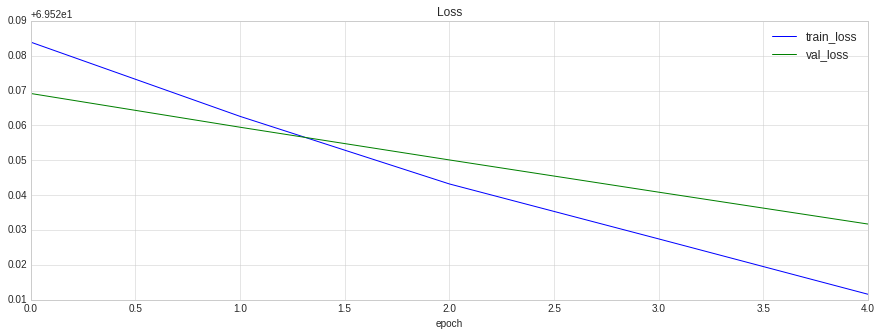

In [5]:
main_loss = t_df[['train_loss', 'val_loss']]
main_loss.plot(figsize=(15,5), title="Loss")

In [6]:
# learn_r = t_df['learn_rate']
# learn_r.plot(figsize=(15,5), title="Learning rate")

In [7]:
# init_learn_rate = 1e-4
# decay_rate = 0.98
# # decay_steps = 16.0
# total_epochs = 1000

# learning_rate = lambda global_step, decay_steps: init_learn_rate * (decay_rate ** (float(global_step) / decay_steps))

# fig = plt.figure(figsize=(15,5))

# def plot_learn_rate(decay_steps):
#     plt.plot(range(total_epochs), [learning_rate(i, decay_steps) for i in range(total_epochs)], label=str(decay_steps))

# for ds in [4., 8., 16.]:
#     plot_learn_rate(ds)

# plt.legend()
# plt.title("Projected Learning Rate")

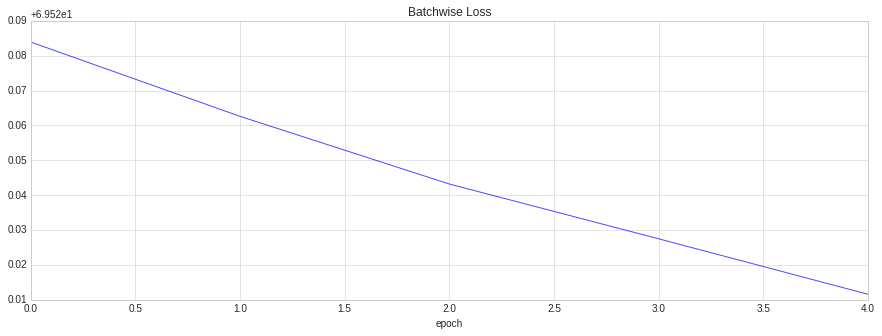

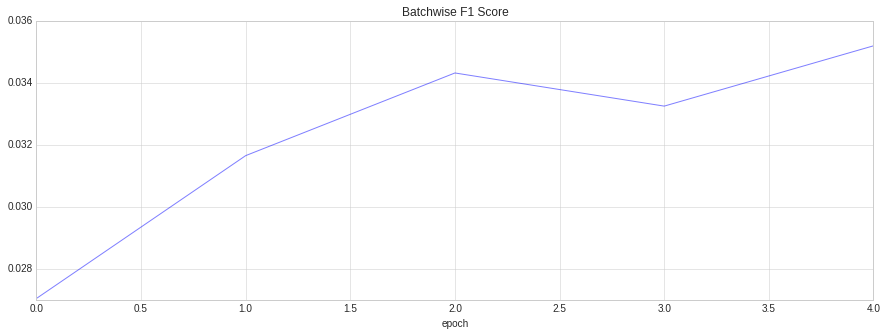

In [9]:
LOSS_LOG_DIR = os.path.join(SOURCE_DIR, "loss_log")
LOSS_LOG_FILE = "loss-{}.csv"

def _py2_read_from_csv(filename, has_header=True):
#     li = []
    count = 0
    with open(filename, 'rb') as f:
        reader = csv.reader(f)
        header = next(reader) if has_header else None
        for row in reader:
            count += 1
#             li.append(row)
#     return li, header
    return header, count

def _py3_read_from_csv(filename, has_header=True):
#     li = []
    count = 0
    with open(filename, 'r', newline='') as f:
        reader = csv.reader(f)
        header = next(reader) if has_header else None
        for row in reader:
            count += 1
#             li.append(row)
#     return li, header
    return header, count

read_from_csv = _py3_read_from_csv if PY3 else _py2_read_from_csv

get_i = lambda f: int(f.split('-')[1].split('.')[0])
log_files = [f for f in glob.glob(os.path.join(LOSS_LOG_DIR, LOSS_LOG_FILE.format("*")))]
log_files = sorted(log_files, key=get_i)

columns, count = read_from_csv(log_files[0])
# print(np.loadtxt(log_files[0], dtype='S20', delimiter=',', skiprows=1).astype(str))

loss_log = lambda f: np.loadtxt(f, dtype='S20', delimiter=',', skiprows=1).astype(float).reshape(-1, len(columns))
loss = np.concatenate([loss_log(f) for f in log_files])

l_df = pd.DataFrame(loss, columns=columns)
l_df['epoch'] = ([float(i)/count for i in l_df.index])
l_df.set_index('epoch', inplace=True)

l_df['loss'].plot(figsize=(15, 5), title="Batchwise Loss", alpha=0.7)
plt.show()
# l_df['loss'].plot(figsize=(15, 5), ylim=(0.0, 1000), title="Loss")
l_df['f1_score'].plot(figsize=(15, 5),  title="Batchwise F1 Score", alpha=0.5)
plt.show()
# l_df.plot(figsize=(15, 5), ylim=(0.0, 100000), title="Loss")
# l_df.plot(figsize=(15, 5), ylim=(0.0, 10000), title="Loss")
# l_df.plot(figsize=(15, 5), ylim=(0.0, 1000), title="Loss")
# l_df.plot(figsize=(15, 5), ylim=(0.0, 100), title="Loss")
# l_df.plot(figsize=(15, 5), ylim=(0.0, 10), title="Loss")
# l_df.plot(figsize=(15, 5), ylim=(0.0, 2), title="Loss", alpha=0.5)

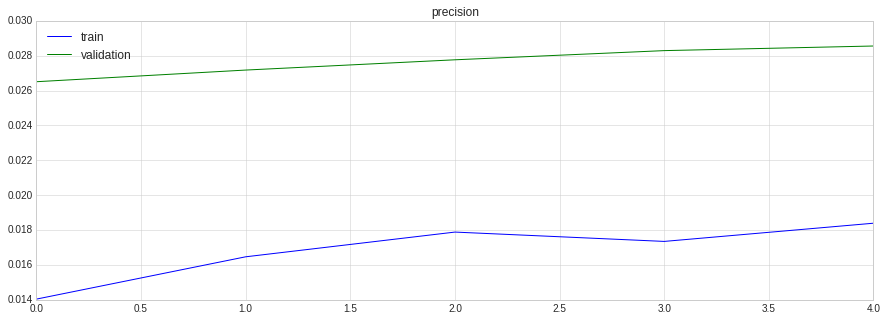

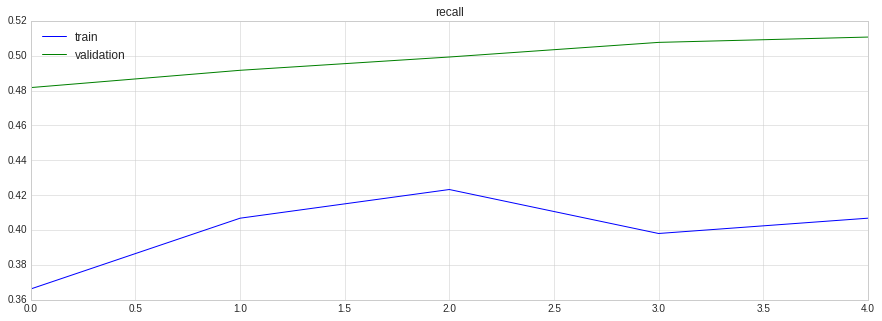

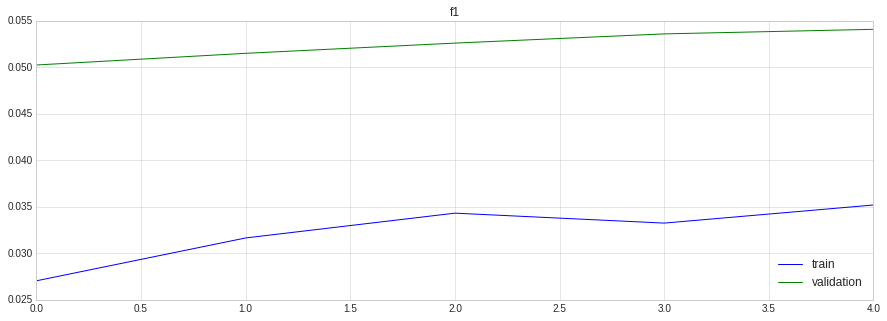

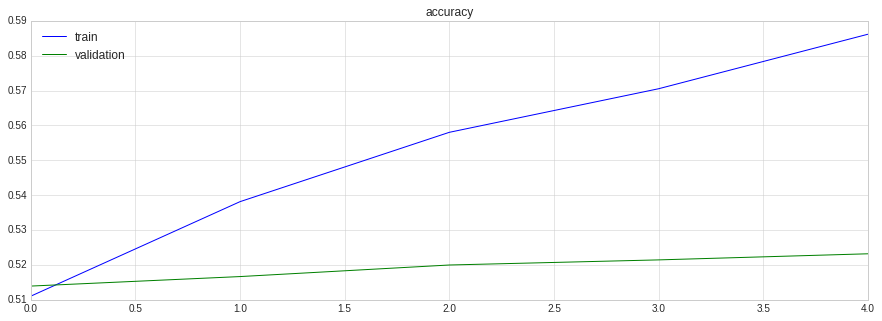

In [10]:
F_STATS_LOG_DIR = os.path.join(SOURCE_DIR, "f_stats_log")
F_STATS_FILE = "f_stats-{}.csv"

F_STATS_VAL_DIR = os.path.join(F_STATS_LOG_DIR, "validation")
F_STATS_TRAIN_DIR = os.path.join(F_STATS_LOG_DIR, "training")

def get_epoch_count():
    return len(glob.glob(os.path.join(F_STATS_VAL_DIR, F_STATS_FILE.format('*'))))

def get_f_stats(src_dir, epoch_count):
    get_sum = lambda i: pd.read_csv(os.path.join(src_dir, F_STATS_FILE.format(i))).sum()
    e_sums = [get_sum(i) for i in range(epoch_count)]
    return pd.concat(e_sums, axis=1).T

def compute_metrics(df):
    smooth = 1e-8
    df['precision'] = (df['true_positive'] + smooth) / (df['true_positive'] + df['false_positive'] + smooth)
    df['recall'] = (df['true_positive'] + smooth) / (df['true_positive'] + df['false_negative'] + smooth)
    df['f1'] = (2 * df['precision'] * df['recall']) / (df['precision'] + df['recall'])
    df['accuracy'] = (df['true_positive'] + df['true_negative']) / \
                     (df['true_positive'] + df['true_negative'] + df['false_positive'] + df['false_negative'])
    return df

epochs = get_epoch_count()
get_metrics = lambda d: compute_metrics(get_f_stats(d, epochs))

train_m = get_metrics(F_STATS_TRAIN_DIR)
val_m = get_metrics(F_STATS_VAL_DIR)

def plot_metrics(column, train_df, val_df):
    df = pd.concat([train_df[column], val_df[column]], axis=1)
    df.columns = ['train', 'validation']
    df.plot(figsize=(15,5), title=column)

for c in ['precision', 'recall', 'f1', 'accuracy']:
    plot_metrics(c, train_m, val_m)

In [11]:
train_m.tail()

,true_positive,false_positive,false_negative,true_negative,precision,recall,f1,accuracy
0,334,23455,578,24785,0.014040,0.366228,0.027043,0.511047
1,371,22160,541,26080,0.016466,0.406798,0.031651,0.538147
2,386,21198,526,27042,0.017884,0.423246,0.034317,0.558024
3,363,20561,549,27679,0.017348,0.398026,0.033248,0.570516
4,371,19801,541,28439,0.018392,0.406798,0.035193,0.586141


In [12]:
val_m.tail()

,true_positive,false_positive,false_negative,true_negative,precision,recall,f1,accuracy
0,632,23211,680,24629,0.026507,0.481707,0.050248,0.513936
1,645,23090,667,24750,0.027175,0.491616,0.051503,0.516663
2,655,22937,657,24903,0.027764,0.499238,0.052602,0.519979
3,666,22876,646,24964,0.028290,0.507622,0.053593,0.521444
4,670,22794,642,25046,0.028554,0.510671,0.054085,0.523193


In [13]:
max_i = val_m['f1'].argmax(); print("Max Index:", max_i)
max_f1 = pd.concat((train_m.iloc[max_i], val_m.iloc[max_i]), axis=1)
max_f1.columns = ['train', 'validation']
max_f1

Max Index: 4


,train,validation
true_positive,371.000000,670.000000
false_positive,19801.000000,22794.000000
false_negative,541.000000,642.000000
true_negative,28439.000000,25046.000000
precision,0.018392,0.028554
recall,0.406798,0.510671
f1,0.035193,0.054085
accuracy,0.586141,0.523193
